In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time
import glob, os, sys
from os import path

### 2. Computing time, please!

In this problem you will evaluate the scaling and parallel performance of a parallel code
on stampede2 and write subsections of a computing allocation request. If you are using
a parallel code for your research you can use that code for this homework. Otherwise, use
Hyperion to complete the exercises below. If you have more than one project allocation
on TACC, you can add `#SBATCH -A ast381` to your submission script to charge our class
allocation for the computing time you use. See notes below on submitting jobs.


a) Scaling and Performance: Install your parallel code of choice on Stampede2 and get it
running. Set up and run a weak and a strong scaling test. Make plots of efficiency versus
number of processors for each of your tests with the results from 1 to at least 64 cores.
Include at least 5 points in each of your scaling relationships. To obtain consistent results,
make sure your jobs run on the same type of processor – on Stampede2 that means either
KNL or SKX processors.


### Strong Scaling

In [34]:
cores_arr = [1, 10, 16, 48, 60, 90]
ss = pd.DataFrame({'cores':cores_arr, 'cpu_time':np.zeros(len(cores_arr))})

path = 'strong_scaling/batchlogs/'

for cores in cores_arr:
    for file in os.listdir(path):
        if 'n{}.o'.format(str(cores)) in file:
            with open(path+file, 'r') as f:
                lines = f.read().splitlines()
                last_line = lines[-3]
                ss.loc[ss['cores']==cores,['cpu_time']] = float(last_line[34:])

ss['wall_time'] = ss['cpu_time']/ss['cores']
ss['speed_up'] = ss['cpu_time'][0]/ss['cpu_time']
ss['e'] = ss['speed_up']/ss['cores']

print(ss_df)

   cores  cpu_time    wall_time  speed_up         e
0      1   2892.70  2892.700000  1.000000  1.000000
1     10   3224.36   322.436000  0.897139  0.089714
2     16   4297.26   268.578750  0.673150  0.042072
3     48   5309.80   110.620833  0.544785  0.011350
4     60   4723.32    78.722000  0.612429  0.010207
5     90   6585.44    73.171556  0.439257  0.004881


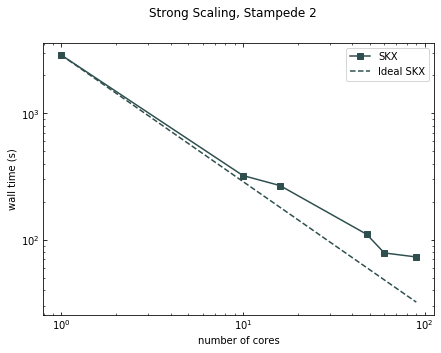

In [52]:
c = 'darkslategray'

fig, ax = plt.subplots(figsize=(7,5))


ax.tick_params(axis="both",which='both', direction="in", bottom=True, top=True,
               left=True, right=True)

ax.plot(ss['cores'], ss['wall_time'], marker='s', label= 'SKX', color = c)
ax.plot(ss['cores'],ss['cpu_time'][0]/ss['cores'], ls='--', label='Ideal SKX',  color = c)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("number of cores")
ax.set_ylabel('wall time (s)')


fig.suptitle('Strong Scaling, Stampede 2')
ax.legend()
ax1.legend()
plt.show()

### Weak Scaling

In [56]:
cores_arr = [1, 10, 16, 48, 90]
ws = pd.DataFrame({'cores':cores_arr, 'cpu_time':np.zeros(len(cores_arr))})

path = 'weak_scaling/batchlogs/'

### grid = (cores*10, 100, 2)
for cores in cores_arr:
    for file in os.listdir(path):
        if 'n{}.o'.format(str(cores)) in file:
            with open(path+file, 'r') as f:
                lines = f.read().splitlines()
                last_line = lines[-3]
                ws.loc[ws['cores']==cores,['cpu_time']] = float(last_line[34:])

ws['e'] = ws['cpu_time'][0]/ws['cpu_time']

print(ws)

   cores  cpu_time         e
0      1    196.10  1.000000
1     10    915.69  0.214155
2     16   1323.59  0.148158
3     48   2144.95  0.091424
4     90    863.12  0.227199


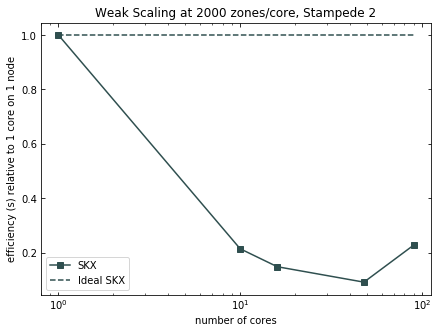

In [57]:
fig, ax = plt.subplots(figsize=(7,5))

ax.tick_params(axis="both",which='both', direction="in", bottom=True, top=True,
               left=True, right=True)

ax.plot(ws['cores'], ws['e'], marker='s', label= 'SKX', color = c)
ax.plot(ws['cores'],[1,1,1,1,1], ls='--', label='Ideal SKX',  color = c)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("number of cores")
plt.ylabel('efficiency (s) relative to 1 core on 1 node')
plt.title('Weak Scaling at 2000 zones/core, Stampede 2')
plt.legend()
plt.show()

c) Describing Performance: Using the Simon et al. code performance document as an
example, write a summary of your tests and the results. Evaluate whether the results are
“good” or not. (Note: if you are working with hyperion, the Robitaille (2011) hyperion
method paper includes some discussion and results for how hyperion scales, which are a useful point of reference.) Comment on any features in the plots. If you find your code
doesn’t scale “well,” you may want to experiment with the problem setup, e.g., in terms of
the size and work per core. )

The strong scaling result is fairly consistent with Simon et al. where we see a slight uptick in wall time as we get to above 10 cores. For the weak scaling results however, I see a sharp drop in efficiency that I would not expect based on Simon et al.'s results. At `n=90` cores, I requested two nodes, which could explain the slight improvement in efficiency. There could also be efficiency lost due to the python wrapped (e.g. running `hyperion` vs. `hyperion_sph`). In the Robitaille (2011): "Only at the end of the iteration, once all processes have received the signal to stop, are the results combined. This last step incurs an overhead, which scales with the number of processes and the grid, image, or SED resolution." This could also be a reason the efficiency scales more "poorly" as we increase the grid size even if we increase the number of cores. The overhead also scales with the grid thus decreasing efficiency. As we scale the number of processors and frid, we also scale the data that needs to be communicated between processors and the latency in communication for the limited bandwidth.

d) Production Science: An important component of a computing time request is the estimate
and justification for the amount of requested computing time and memory storage. Formulate
a substantive science project using Hyperion or your research code. The project should
require a significant amount of HPC resources (e.g., > 103 hours) but not so much that it is
infeasible to complete during a typical proposal cycle (1 year, plus allowing for other users
to also use the machine!). Using the example xsede proposals (https://portal.xsede.
org/allocations/research), your results from above, and our class notes as guides, write
a request for computing resources at TACC. The request should include a brief description of
the proposed problem, outline the runs to be carried out and present a quantitative estimate
of how much time and memory the calculations will require. The intent here is not to
write a complete 10-page proposal (much of which is science background) but to instead focus
on designing a computing study, describing its execution and justifying computing resources
(e.g., 1-2 pages).